In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
import time

import stylegan.model
import stylegan.encoder

import json
from tqdm import tqdm
from functools import partialmethod

tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

import data
import utils
import optimizer
import evaluater

np.random.seed(123)
%load_ext autoreload
%autoreload 2

# CelebA

In [ ]:
device = torch.device('cuda')

fixed_z = torch.randn(32, 512).to(device)
fixed_noise = []
for i in range(2, 7):
    fixed_noise.append(torch.randn((32, 1, 2**i, 2**i), dtype=torch.float, device=device))

gen = stylegan.model.StyledGenerator(512).to(device)
ckpt = torch.load('./out/models/stylegan.sd')
gen.load_state_dict(ckpt['g_running'])
gen.start_layer = 0
gen.end_layer = 4
fixed_w = gen.style(fixed_z)

x_fake = gen(fixed_w, noise=fixed_noise, input_is_latent=True, alpha=1)[1]
x_fake = (x_fake - (-1)) / (1 - (-1))
x_fake = x_fake.detach().cpu().numpy()
utils.plot_grid(np.vstack([x_fake[:16], x_fake[16:32], x_fake[32:48], x_fake[48:64]]), figsize=(8,8))

In [ ]:
n_samples = 1024
batch_size = 64
restarts = 5

ids = [0]

device = torch.device('cuda')
dataloader, imsize = data.load(name='CelebA', path='./data/CelebA/CelebA.h5', batch_size=batch_size, num_workers=8)

gen = stylegan.model.StyledGenerator(512).to(device)
ckpt = torch.load('./out/models/stylegan.sd')
gen.load_state_dict(ckpt['g_running'])
gen = nn.DataParallel(gen, device_ids=ids)
gen.eval()

enc = stylegan.encoder.StyleGANEncoderNet(64, w_plus=False).to(device)
ckpt = torch.load("./out/models/stylegan_encoder.sd")
enc.load_state_dict(ckpt['enc'])
enc = nn.DataParallel(enc, device_ids=ids)
enc.eval()

In [ ]:
config = {'arch': 'stylegan',
          'device': device,
          'meas_fn': utils.torch_magnitudes,
          'dist_fn': lambda X, Y: torch.mean((X - Y)**2, dim=(1,2,3)),
          'start_layer': 0, 'end_layer': 4,
          'latent_size': (512,),
          'lr': [0.1, 0.1, 0.1, 0.1, 0.1], 'lr_rampdown': 0.25, 'lr_rampup': 0.05,
          'im_steps': [],
          'random_init': 5000,
          }

file = "./out/reconstructions/stylegan/CelebA_mii"
file = None
latent = None

batch, out, latent, noise = optimizer.run(gen, config, dataloader['test'], imsize, n_samples=n_samples, batch_size=batch_size, restarts=restarts, z_init=latent, file=file)

new_out = utils.pick_results(batch, out)
for i in range(new_out.shape[1]):
    print("PSNR: {:.4f} +/- {:.4f}\nSSIM: {:.4f} +/- {:.4f}\nLPIPS: {:.4f} +/- {:.4f}\n".format(
        *evaluater.benchmark(batch, new_out[:,i], measure='psnr'), 
        *evaluater.benchmark(batch, new_out[:,i], measure='ssim'), 
        *evaluater.benchmark(batch, new_out[:,i], measure='lpips')
    ))
utils.plot_grid(np.vstack([batch[:16], new_out[:16, -1]]), figsize=(8,8))

In [ ]:
config = {'arch': 'stylegan',
          'device': device,
          'meas_fn': utils.torch_magnitudes,
          'dist_fn': lambda X, Y: torch.mean((X - Y)**2, dim=(1,2,3)),
          'start_layer': 0, 'end_layer': 4,
          'latent_size': (512,),
          'lr': [0.1, 0.1, 0.1, 0.1, 0.1], 'lr_rampdown': 0.25, 'lr_rampup': 0.05,
          'im_steps': [(3000,0,1)],
          'pgd': False,
          'mahalanobis': False,
          'normalize': True,
          'keep_im' : False,
          'random_init': 1,
          'negate': True,
          }


file = "./out/reconstructions/stylegan/CelebA_dpr"
latent = None

batch, out, latent, noise = optimizer.run(gen, config, dataloader['test'], imsize, n_samples=n_samples, batch_size=batch_size, restarts=restarts, z_init=latent, file=file)

new_out = utils.pick_results(batch, out)
for i in range(new_out.shape[1]):
    print("PSNR: {:.4f} +/- {:.4f}\nSSIM: {:.4f} +/- {:.4f}\nLPIPS: {:.4f} +/- {:.4f}\n".format(
        *evaluater.benchmark(batch, new_out[:,i], measure='psnr'), 
        *evaluater.benchmark(batch, new_out[:,i], measure='ssim'), 
        *evaluater.benchmark(batch, new_out[:,i], measure='lpips')
    ))
utils.plot_grid(np.vstack([batch[:16], new_out[:16, -1]]), figsize=(8,8))

PSNR: 16.2040 +/- 0.3415
SSIM: 0.4053 +/- 0.0161
LPIPS: 0.3496 +/- 0.0097

PSNR: 17.2310 +/- 0.3577
SSIM: 0.4466 +/- 0.0171
LPIPS: 0.3327 +/- 0.0104

PSNR: 17.8854 +/- 0.3646
SSIM: 0.4730 +/- 0.0175
LPIPS: 0.3213 +/- 0.0107

PSNR: 18.1893 +/- 0.3702
SSIM: 0.4837 +/- 0.0179
LPIPS: 0.3180 +/- 0.0109



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR: 18.2606 +/- 0.3745
SSIM: 0.4859 +/- 0.0181
LPIPS: 0.3184 +/- 0.0112



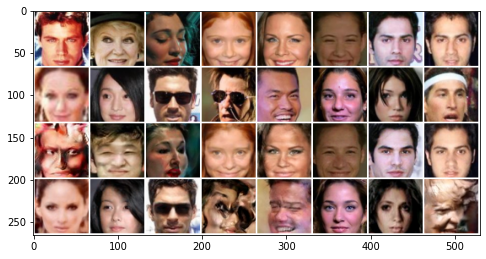

In [2]:
batch, out, latent, noise = utils.load_results("./out/reconstructions/stylegan/CelebA_dpr")
new_out = utils.pick_results(batch, out)
for i in range(new_out.shape[1]):
    print("PSNR: {:.4f} +/- {:.4f}\nSSIM: {:.4f} +/- {:.4f}\nLPIPS: {:.4f} +/- {:.4f}\n".format(
        *evaluater.benchmark(batch, new_out[:,i], measure='psnr'), 
        *evaluater.benchmark(batch, new_out[:,i], measure='ssim'), 
        *evaluater.benchmark(batch, new_out[:,i], measure='lpips')
    ))
utils.plot_grid(np.vstack([batch[:16], new_out[:16, -1]]), figsize=(8,8))

In [ ]:
config = {'arch': 'stylegan',
          'device': device,
          'meas_fn': utils.torch_magnitudes,
          'dist_fn': lambda X, Y: torch.mean((X - Y)**2, dim=(1,2,3)),
          'start_layer': 0, 'end_layer': 4,
          'latent_size': (512,),
          'lr': [0.1, 0.1, 0.1, 0.1, 0.1], 'lr_rampdown': 0.25, 'lr_rampup': 0.05,
          'im_steps': [(3000,0,1)],
          'pgd': False,
          'mahalanobis': False,
          'normalize': True,
          'keep_im' : False,
          'random_init': 0,
          }


file = "./out/reconstructions/stylegan/CelebA_dpr-mii"
latent = None
batch, out, latent, noise = utils.load_results("./out/reconstructions/stylegan/CelebA_mii")

batch, out, latent, noise = optimizer.run(gen, config, dataloader['test'], imsize, n_samples=n_samples, batch_size=batch_size, restarts=restarts, z_init=latent, file=file)

new_out = utils.pick_results(batch, out)
for i in range(new_out.shape[1]):
    print("PSNR: {:.4f} +/- {:.4f}\nSSIM: {:.4f} +/- {:.4f}\nLPIPS: {:.4f} +/- {:.4f}\n".format(
        *evaluater.benchmark(batch, new_out[:,i], measure='psnr'), 
        *evaluater.benchmark(batch, new_out[:,i], measure='ssim'), 
        *evaluater.benchmark(batch, new_out[:,i], measure='lpips')
    ))
utils.plot_grid(np.vstack([batch[:16], new_out[:16, -1]]), figsize=(8,8))

PSNR: 18.6165 +/- 0.3348
SSIM: 0.5204 +/- 0.0159
LPIPS: 0.2833 +/- 0.0091

PSNR: 19.5595 +/- 0.3335
SSIM: 0.5616 +/- 0.0157
LPIPS: 0.2653 +/- 0.0091

PSNR: 19.9035 +/- 0.3334
SSIM: 0.5752 +/- 0.0157
LPIPS: 0.2588 +/- 0.0092

PSNR: 20.2888 +/- 0.3270
SSIM: 0.5933 +/- 0.0154
LPIPS: 0.2505 +/- 0.0092



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR: 20.3889 +/- 0.3279
SSIM: 0.5972 +/- 0.0154
LPIPS: 0.2493 +/- 0.0093



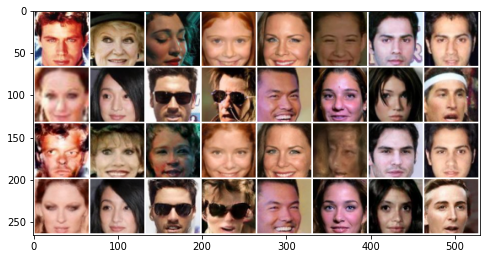

In [4]:
batch, out, latent, noise = utils.load_results("./out/reconstructions/stylegan/CelebA_dpr-mii")
new_out = utils.pick_results(batch, out)
for i in range(new_out.shape[1]):
    print("PSNR: {:.4f} +/- {:.4f}\nSSIM: {:.4f} +/- {:.4f}\nLPIPS: {:.4f} +/- {:.4f}\n".format(
        *evaluater.benchmark(batch, new_out[:,i], measure='psnr'), 
        *evaluater.benchmark(batch, new_out[:,i], measure='ssim'), 
        *evaluater.benchmark(batch, new_out[:,i], measure='lpips')
    ))
utils.plot_grid(np.vstack([batch[:16], new_out[:16, -1]]), figsize=(8,8))

In [ ]:
config = {'arch': 'stylegan',
          'device': device,
          'meas_fn': utils.torch_magnitudes,
          'dist_fn': lambda X, Y: torch.mean((X - Y)**2, dim=(1,2,3)),
          'start_layer': 0, 'end_layer': 4,
          'latent_size': (512,),
          'lr': [0.1, 0.1, 0.1, 0.1, 0.1], 'lr_rampdown': 0.25, 'lr_rampup': 0.05,
          'im_steps': [(3000,0,1)],
          'pgd': False,
          'mahalanobis': False,
          'normalize': True,
          'keep_im' : False,
          'init_enc': (enc, [0,0,0,0,0]),
          'random_init': 0,
          'z_noise': 0.05,
          'gradient_noise': 0.02,
          }


file = "./out/reconstructions/stylegan/CelebA_dpr-li"
latent = None

batch, out, latent, noise = optimizer.run(gen, config, dataloader['test'], imsize, n_samples=n_samples, batch_size=batch_size, restarts=restarts, z_init=latent, file=file)

new_out = utils.pick_results(batch, out)
for i in range(new_out.shape[1]):
    print("PSNR: {:.4f} +/- {:.4f}\nSSIM: {:.4f} +/- {:.4f}\nLPIPS: {:.4f} +/- {:.4f}\n".format(
        *evaluater.benchmark(batch, new_out[:,i], measure='psnr'), 
        *evaluater.benchmark(batch, new_out[:,i], measure='ssim'), 
        *evaluater.benchmark(batch, new_out[:,i], measure='lpips')
    ))
utils.plot_grid(np.vstack([batch[:16], new_out[:16, -1]]), figsize=(8,8))

PSNR: 21.8958 +/- 0.2589
SSIM: 0.6734 +/- 0.0119
LPIPS: 0.2157 +/- 0.0067

PSNR: 22.2493 +/- 0.2534
SSIM: 0.6876 +/- 0.0116
LPIPS: 0.2090 +/- 0.0066

PSNR: 22.4293 +/- 0.2481
SSIM: 0.6949 +/- 0.0114
LPIPS: 0.2061 +/- 0.0066

PSNR: 22.5786 +/- 0.2443
SSIM: 0.7014 +/- 0.0111
LPIPS: 0.2030 +/- 0.0065



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR: 22.6223 +/- 0.2455
SSIM: 0.7021 +/- 0.0112
LPIPS: 0.2022 +/- 0.0065



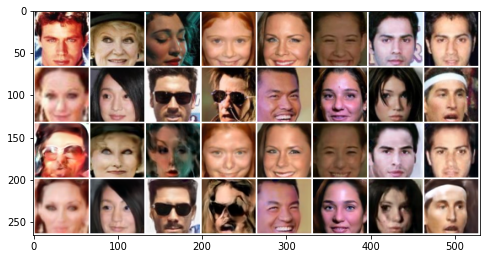

In [5]:
batch, out, latent, noise = utils.load_results("./out/reconstructions/stylegan/CelebA_dpr-li")
new_out = utils.pick_results(batch, out)
for i in range(new_out.shape[1]):
    print("PSNR: {:.4f} +/- {:.4f}\nSSIM: {:.4f} +/- {:.4f}\nLPIPS: {:.4f} +/- {:.4f}\n".format(
        *evaluater.benchmark(batch, new_out[:,i], measure='psnr'), 
        *evaluater.benchmark(batch, new_out[:,i], measure='ssim'), 
        *evaluater.benchmark(batch, new_out[:,i], measure='lpips')
    ))
utils.plot_grid(np.vstack([batch[:16], new_out[:16, -1]]), figsize=(8,8))

In [ ]:
config = {'arch': 'stylegan',
          'device': device,
          'meas_fn': utils.torch_magnitudes,
          'dist_fn': lambda X, Y: torch.mean((X - Y)**2, dim=(1,2,3)),
          'start_layer': 0, 'end_layer': 4,
          'latent_size': (512,),
          'lr': [0.1, 0.1, 0.1, 0.1, 0.1], 'lr_rampdown': 0.25, 'lr_rampup': 0.05,
          'im_steps': [(100,1000,1), (100,200,1), (100,200,1)],    
          'noise_radii': [],
          'latent_radii': [1000, 100, 100, 100, 100],
          'back_steps': [(100,1000,0),(100,1000,0)],
          'pgd': True,
          'mahalanobis': False,
          'normalize': True,
          'keep_im' : True,
          'random_init': 1,
          'negate': True,
          }

file = "./out/reconstructions/stylegan/CelebA_prilo"
latent = None

batch, out, latent, noise = optimizer.run(gen, config, dataloader['test'], imsize, n_samples=n_samples, batch_size=batch_size, restarts=restarts, z_init=latent, file=file)

new_out = utils.pick_results(batch, out)
for i in range(new_out.shape[1]):
    print("PSNR: {:.4f} +/- {:.4f}\nSSIM: {:.4f} +/- {:.4f}\nLPIPS: {:.4f} +/- {:.4f}\n".format(
        *evaluater.benchmark(batch, new_out[:,i], measure='psnr'), 
        *evaluater.benchmark(batch, new_out[:,i], measure='ssim'), 
        *evaluater.benchmark(batch, new_out[:,i], measure='lpips')
    ))
utils.plot_grid(np.vstack([batch[:16], new_out[:16, -1]]), figsize=(8,8))

PSNR: 16.0086 +/- 0.3232
SSIM: 0.4047 +/- 0.0152
LPIPS: 0.3475 +/- 0.0092

PSNR: 17.2006 +/- 0.3390
SSIM: 0.4562 +/- 0.0160
LPIPS: 0.3218 +/- 0.0096

PSNR: 17.8716 +/- 0.3445
SSIM: 0.4851 +/- 0.0163
LPIPS: 0.3082 +/- 0.0098

PSNR: 18.3335 +/- 0.3458
SSIM: 0.5063 +/- 0.0164
LPIPS: 0.2995 +/- 0.0099



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR: 18.5542 +/- 0.3435
SSIM: 0.5143 +/- 0.0165
LPIPS: 0.2952 +/- 0.0100



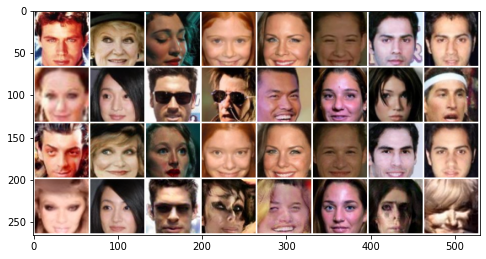

In [6]:
batch, out, latent, noise = utils.load_results("./out/reconstructions/stylegan/CelebA_prilo")
new_out = utils.pick_results(batch, out)
for i in range(new_out.shape[1]):
    print("PSNR: {:.4f} +/- {:.4f}\nSSIM: {:.4f} +/- {:.4f}\nLPIPS: {:.4f} +/- {:.4f}\n".format(
        *evaluater.benchmark(batch, new_out[:,i], measure='psnr'), 
        *evaluater.benchmark(batch, new_out[:,i], measure='ssim'), 
        *evaluater.benchmark(batch, new_out[:,i], measure='lpips')
    ))
utils.plot_grid(np.vstack([batch[:16], new_out[:16, -1]]), figsize=(8,8))

In [ ]:
config = {'arch': 'stylegan',
          'device': device,
          'meas_fn': utils.torch_magnitudes,
          'dist_fn': lambda X, Y: torch.mean((X - Y)**2, dim=(1,2,3)),
          'start_layer': 0, 'end_layer': 4,
          'latent_size': (512,),
          'lr': [0.1, 0.1, 0.1, 0.1, 0.1], 'lr_rampdown': 0.25, 'lr_rampup': 0.05,
          'im_steps': [(2000,1000,1), (400,100,3)],    
          'noise_radii': [],
          'latent_radii': [1000, 100, 100, 100, 100],
          'back_steps': [(100,1000,0)],
          'pgd': True,
          'mahalanobis': False,
          'normalize': True,
          'keep_im' : True,
          'random_init': 0,
          }


file = "./out/reconstructions/stylegan/CelebA_prilo-mii"
latent = None
batch, out, latent, noise = utils.load_results("./out/reconstructions/stylegan/CelebA_mii")

batch, out, latent, noise = optimizer.run(gen, config, dataloader['test'], imsize, n_samples=n_samples, batch_size=batch_size, restarts=restarts, z_init=latent, file=file)

new_out = utils.pick_results(batch, out)
for i in range(new_out.shape[1]):
    print("PSNR: {:.4f} +/- {:.4f}\nSSIM: {:.4f} +/- {:.4f}\nLPIPS: {:.4f} +/- {:.4f}\n".format(
        *evaluater.benchmark(batch, new_out[:,i], measure='psnr'), 
        *evaluater.benchmark(batch, new_out[:,i], measure='ssim'), 
        *evaluater.benchmark(batch, new_out[:,i], measure='lpips')
    ))
utils.plot_grid(np.vstack([batch[:16], new_out[:16, -1]]), figsize=(8,8))

PSNR: 20.9644 +/- 0.2994
SSIM: 0.6154 +/- 0.0136
LPIPS: 0.2536 +/- 0.0088

PSNR: 21.2616 +/- 0.2959
SSIM: 0.6292 +/- 0.0135
LPIPS: 0.2459 +/- 0.0087

PSNR: 21.3252 +/- 0.2965
SSIM: 0.6321 +/- 0.0135
LPIPS: 0.2440 +/- 0.0088

PSNR: 21.3873 +/- 0.2973
SSIM: 0.6342 +/- 0.0135
LPIPS: 0.2435 +/- 0.0088



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR: 21.4223 +/- 0.2973
SSIM: 0.6358 +/- 0.0135
LPIPS: 0.2429 +/- 0.0088



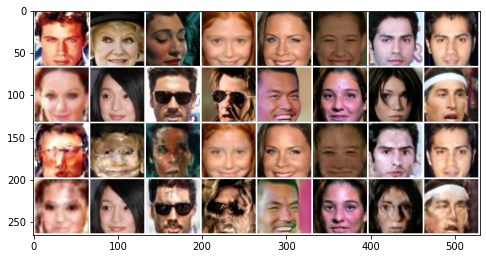

In [7]:
batch, out, latent, noise = utils.load_results("./out/reconstructions/stylegan/CelebA_prilo-mii")
new_out = utils.pick_results(batch, out)
for i in range(new_out.shape[1]):
    print("PSNR: {:.4f} +/- {:.4f}\nSSIM: {:.4f} +/- {:.4f}\nLPIPS: {:.4f} +/- {:.4f}\n".format(
        *evaluater.benchmark(batch, new_out[:,i], measure='psnr'), 
        *evaluater.benchmark(batch, new_out[:,i], measure='ssim'), 
        *evaluater.benchmark(batch, new_out[:,i], measure='lpips')
    ))
utils.plot_grid(np.vstack([batch[:16], new_out[:16, -1]]), figsize=(8,8))

In [ ]:
config = {'arch': 'stylegan',
          'device': device,
          'meas_fn': utils.torch_magnitudes,
          'dist_fn': lambda X, Y: torch.mean((X - Y)**2, dim=(1,2,3)),
          'start_layer': 0, 'end_layer': 4,
          'latent_size': (512,),
          'lr': [0.1, 0.1, 0.1, 0.1, 0.1], 'lr_rampdown': 0.25, 'lr_rampup': 0.05,
          'im_steps': [(2000,1000,1), (400,100,3)],    
          'noise_radii': [],
          'latent_radii': [1000, 100, 100, 100, 100],
          'back_steps': [(100,1000,0)],
          'pgd': True,
          'mahalanobis': False,
          'normalize': True,
          'keep_im' : True,
          'init_enc': (enc, [0,0,0,0,0]),
          'random_init': 0,
          'z_noise': 0.05,
          'gradient_noise': 0.02,
          }


file = "./out/reconstructions/stylegan/CelebA_prilo-li"
file = None
latent = None

batch, out, latent, noise = optimizer.run(gen, config, dataloader['test'], imsize, n_samples=n_samples, batch_size=batch_size, restarts=restarts, z_init=latent, file=file)

new_out = utils.pick_results(batch, out)
for i in range(new_out.shape[1]):
    print("PSNR: {:.4f} +/- {:.4f}\nSSIM: {:.4f} +/- {:.4f}\nLPIPS: {:.4f} +/- {:.4f}\n".format(
        *evaluater.benchmark(batch, new_out[:,i], measure='psnr'), 
        *evaluater.benchmark(batch, new_out[:,i], measure='ssim'), 
        *evaluater.benchmark(batch, new_out[:,i], measure='lpips')
    ))
utils.plot_grid(np.vstack([batch[:16], new_out[:16, -1]]), figsize=(8,8))

PSNR: 22.7825 +/- 0.2819
SSIM: 0.7047 +/- 0.0123
LPIPS: 0.1970 +/- 0.0072

PSNR: 23.0546 +/- 0.2763
SSIM: 0.7139 +/- 0.0122
LPIPS: 0.1923 +/- 0.0071

PSNR: 23.1594 +/- 0.2729
SSIM: 0.7181 +/- 0.0122
LPIPS: 0.1904 +/- 0.0072

PSNR: 23.2620 +/- 0.2710
SSIM: 0.7221 +/- 0.0120
LPIPS: 0.1884 +/- 0.0071



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR: 23.3378 +/- 0.2691
SSIM: 0.7247 +/- 0.0120
LPIPS: 0.1872 +/- 0.0071



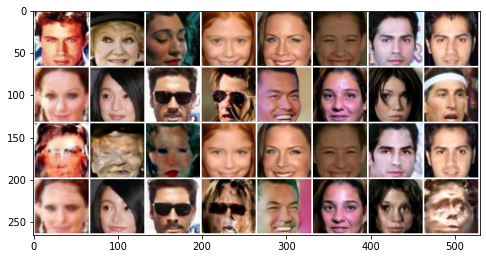

In [8]:
batch, out, latent, noise = utils.load_results("./out/reconstructions/stylegan/CelebA_prilo-li")
new_out = utils.pick_results(batch, out)
for i in range(new_out.shape[1]):
    print("PSNR: {:.4f} +/- {:.4f}\nSSIM: {:.4f} +/- {:.4f}\nLPIPS: {:.4f} +/- {:.4f}\n".format(
        *evaluater.benchmark(batch, new_out[:,i], measure='psnr'), 
        *evaluater.benchmark(batch, new_out[:,i], measure='ssim'), 
        *evaluater.benchmark(batch, new_out[:,i], measure='lpips')
    ))
utils.plot_grid(np.vstack([batch[:16], new_out[:16, -1]]), figsize=(8,8))